 # 폰트, 원 사진 함께 제출

In [109]:
!pip install konlpy --quiet
!pip install customized_konlpy --quiet
!pip install wordcloud

In [3]:
%%writefile bdp_final_project_20210388.py

import time
import datetime
from time import localtime, strftime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager # Chrome driver 자동 업데이트
from selenium.common.exceptions import NoSuchElementException,StaleElementReferenceException
import pandas as pd
import numpy as np
import re            #Regular expression을 이용해 문자열을 다룰 수 있는 모듈
import pickle        #텍스트 상태의 데이터가 아닌 파이썬 객체 자체를 바이너리 파일로 저장
from tqdm import tqdm, trange    #반복문 실행시 진행상태 표시
from glob import glob            #파일과 폴더경로 불러오기
import itertools                 #반복 연산의 효율성과 빠른 실행을 위한 라이브러리
from collections import Counter  #객체를 세는 데 사용
from unicodedata import normalize   #유니코드 문자열 unistr에 대한 정규화 형식 반환
import nltk                      #자연어 처리 및 문서 분석
from ckonlpy.tag import Twitter  #형태소 분석기
from konlpy.tag import Okt
import seaborn as sns            #통계 시각화
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import pickle

def checkTime(func):
    def new_func(*args, **kwargs):
        time_str = strftime("현재시간 : [%Y-%m-%d %H:%M]", localtime())
        print(time_str)
        current_time = time.time()
        func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - current_time
        if duration < 60:
            print("\n게시글 크롤링에 {}초가 소요되었습니다.\n=======================================================".format(round(duration,2)))
        else:
            print("\n게시글 크롤링에 {}분 {}초가 소요되었습니다.\n=======================================================".format(int(duration//60), round(duration%60,2)))
    return new_func

# 크롤링 클래스
class Crawling(object):

    def __init__(self, keyword):
        self._df1 = pd.DataFrame(columns = ['title', 'content', 'comment']) # 크롤링 결과를 저장할 데이터프레임
        self._keyword = keyword # 입력 받을 검색어
        print("'" + str(self.keyword) + "' 라는 키워드로 크롤링을 시작합니다.\n=======================================================")
        
    @property
    def df1(self):
        return self._df1
    @df1.setter
    def df1(self, dataframe_value):
        self._df1 = dataframe_value
    
    @property
    def keyword(self):
        return self._keyword
    @keyword.setter
    def keyword(self, value):
        self._keyword = value
    
    
# '블라인드' 크롤링 클래스    
class BlindCrawling(Crawling):
    
    def __init__(self, keyword):
        Crawling.__init__(self, keyword)
        self._chrome_options = None
        self._service = None
        self._driver = None
        self._page_length = None
        self.process()
        
    @property
    def chrome_options(self):
        return self._chrome_options
    @chrome_options.setter
    def chrome_options(self, value):
        self._chrome_options = value
        
    @property
    def service(self):
        return self._service
    @service.setter
    def service(self, value):
        self._service = value
        
    @property
    def driver(self):
        return self._driver
    @driver.setter
    def driver(self, value):
        self._driver = value
        
    @property
    def page_length(self):
        return self._page_length
    @page_length.setter
    def page_length(self, value):
        self._page_length = value
    
    def move_to_page(self):
        self.chrome_options = Options() # 브라우저 꺼짐 방지
        self.chrome_options.add_experimental_option("detach", True)
        self.chrome_options.add_experimental_option("excludeSwitches", ["enable-logging"]) # 불필요한 에러메시지 노출 방지
        self.service = Service(excutable_path=ChromeDriverManager().install()) # Chrome driver Manager를 통해 크롬 드라이버 자동 설치
        self.driver = webdriver.Chrome(service=self.service, options = self.chrome_options)

        self.driver.implicitly_wait(10)
        self.driver.get("https://www.teamblind.com/kr/") # 이동하려는 해당 웹페이지 주소

        buttonTag = self.driver.find_element(By.CLASS_NAME, 'btn-srch') # 검색 버튼
        buttonTag.click() # 클릭
        inputTag = self.driver.find_element(By.ID, 'keyword') # 검색어 입력창
        inputTag.send_keys(self.keyword+'\n') # 입력창에 검색어 보내기
        self.page_length = self.driver.find_element(By.TAG_NAME, 'option').text # 전체 글 수 추출하기
        p = re.compile('\(([^)]+)') # 정규표현식으로 괄호 안 숫자 추출
        m = p.findall(self.page_length)
        self.page_length = int(m[0])
        print("총 게시글 수는 {}개 입니다.".format(self.page_length)) # 총 게시글 수 출력
        
    def infinite_scrolling(self):
        print("웹 페이지 맨 아래로 스크롤 다운합니다.")
        import time
        prev_height = self.driver.execute_script("return document.body.scrollHeight") # 웹페이지 맨 아래까지 무한 스크롤
        while True:
            self.driver.execute_script("window.scrollTo(0,document.body.scrollHeight)") # 스크롤을 화면 가장 아래로 내린다
            time.sleep(2) # 페이지 로딩 대기
            curr_height = self.driver.execute_script("return document.body.scrollHeight") # 현재 문서 높이를 가져와서 저장
            if(curr_height == prev_height):
                break
            else:
                prev_height = self.driver.execute_script("return document.body.scrollHeight")
        print("웹 페이지 맨 아래로 이동을 완료하였습니다.\n=======================================================")
        
    def start_crawling(self):           
        for i in range(1, self.page_length+1): 
            print("{}번째 게시물을 방문합니다.".format(i)) # 게시물 방문하기
            path = "//*[@id=\"wrap\"]/section/div/div/div[4]/div[{}]/div[1]/h3/a".format(i)
            try: 
                element = self.driver.find_element(By.XPATH, path)
                # element에서 사이트 링크 구하기
                link = element.get_attribute("href")
                # 새 탭 열기
                self.driver.execute_script("window.open('{}');".format(link))
                time.sleep(3)
                # 새 탭으로 커서 이동
                self.driver.switch_to.window(self.driver.window_handles[-1])
                time.sleep(2)
            except NoSuchElementException: # 페이지가 존재하지 않는다면
                print("해당 페이지가 없습니다.")
                break
                #driver.close()
                # 메인 페이지로 이동
                self.driver.switch_to.window(driver.window_handles[-1])
                time.sleep(3)     

            # 제목
            title_path = "//*[@id=\"wrap\"]/section/div/div[2]/div[1]/h2"
            title = self.driver.find_element(By.XPATH, title_path)
            #print(title.text)

            # 내용
            content_path = "//*[@id=\"contentArea\"]"
            content = self.driver.find_element(By.XPATH, content_path)
            #print(content.text)

            # 댓글
            comment = [e.text for e in self.driver.find_elements(By.CLASS_NAME, 'cmt-txt')]

            self.df1.loc[i-1] = [title.text, content.text, ' '.join(comment)] # 데이터프레임에 저장
            # 새 탭 닫기
            self.driver.close()
            # 메인 페이지로 이동
            self.driver.switch_to.window(self.driver.window_handles[-1])
            time.sleep(3)
            
        print("\n\n데이터프레임 정보\n=======================================================")
        print(self.df1.info())
        self.df1['all'] = self.df1['title'] + " " + self.df1['content'] + " " + self.df1['comment'] # 내용을 한 데 합친 all 칼럼 생성
        self.df1.to_csv('bdp_crawling_result.csv') # csv 파일로 내보내기
        
    @checkTime
    def process(self):
        self.move_to_page()
        self.infinite_scrolling()
        self.start_crawling()
        
        
# 형태소 분석 클래스
class TextAnalyzer(object):
    def __init__(self, crawling_obj):
        print("\n\n데이터프레임을 출력합니다.\n=======================================================")
        print(crawling_obj.df1.head())
        self._data_1 = crawling_obj.df1[['all']] # data_1에 df1을 복사함
        self._counts = None
        self._document = None 
        self.process()
    
    @property
    def data_1(self):
        return self._data_1
    @data_1.setter
    def data_1(self, dataframe_value):
        self._data_1 = dataframe_value
        
    @property
    def counts(self):
        return self._counts
    @counts.setter
    def counts(self, value):
        self._counts = value
    
    @property
    def document(self):
        return self._document
    @document.setter
    def document(self, value):
        self._document = value
        
    def preprocessing(self): # 전처리 메서드
        self.data_1.columns=['all'] 
        self.data_1['all'] =  self.data_1['all'].str.replace("[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","") # 특수문자 제거
        self.data_1['all'].replace('', np.nan, inplace=True)

        self.data_1 = self.data_1.drop_duplicates(subset=['all']).dropna(subset=['all']) # 중복 제거
        self.data_1['all'] = self.data_1['all'].str.replace("\n"," ") # \n 제거
        print("\n\n전처리가 완료되었습니다.\n=======================================================")
        
    @staticmethod
    def _text_cleaning(news): # 텍스트 클리닝
        pattern = r'[^\w\s]'
        news = re.sub(pattern=pattern, repl=' ', string=news)
        list_char = ['[', ']', ',' ]
        for char in list_char:
            news = news.replace(char, ' ')
        return news

    @staticmethod
    def word_count(news_series, additional_words=None, stop_words_specific=None, dict_replace=None, dict_space=None):

        now = datetime.datetime.now()
        print(now)
        lines = news_series
        
        list_news = list() # 텍스트 클리닝
        for line in lines:
            for word in dict_space.keys(): # 띄어쓰기가 들어가는 단어 붙이기
                line = str(line).replace(word, dict_space[word])
            list_news.append(TextAnalyzer._text_cleaning(str(line))) # 특수문자들 제거
        tagger = Twitter() #twitter = Okt()
        if len(additional_words) != 0:
            tagger.add_dictionary(additional_words, 'Noun') # list형태의 사용자 지정 단어 추가(명사)
        if len(stop_words_specific) != 0:
            tagger.add_dictionary(stop_words_specific, 'Noun') # 카운트 하지 않을 단어 목록
        
        sentences_tag = list() 
        for sentence in tqdm(list_news): # 형태소로 분리
            morph = tagger.pos(sentence)
            sentences_tag.append(morph)

        list_word_class = ['Noun'] # 필요한 품사 리스트 - Noun, Adj, Verb 등
        document = list() # 형태소 분석한 결과 집합
        
        for sentence1 in sentences_tag: # 각각의 게시글
            list_each_write = list()
            for word, tag in sentence1: # 각각의 형태소
                if ((tag in list_word_class) & (word not in stop_words_specific) & (len(word) != 1)) \
                | ((len(word) == 1) & (word in additional_words)):
                    if word in list(dict_replace.keys()): # 특정 단어들 replace
                        word = dict_replace[word]
                    list_each_write.append(word)
            document.append(list_each_write)
        
        flatten = lambda x: list(itertools.chain.from_iterable(x)) # flattening
        text = nltk.Text(flatten(document))

        num_token = 30000
        print('\n전체 토큰 갯수: {}'.format(len(text.tokens)))
        print('유니크 토큰 갯수: {}'.format(len(set(text.tokens))))
        counts = text.vocab().most_common(num_token)
        
        #형태소 분석 결과 저장
        with open('doc_blind.pickle', 'wb') as f:
            pickle.dump(document, f, pickle.HIGHEST_PROTOCOL)

        #워드클라우드와 빈도분석을 위한 파일 저장
        with open('counts_blind.pickle', 'wb') as f:
            pickle.dump(counts, f, pickle.HIGHEST_PROTOCOL)
            
        return counts, document
    
    def process(self):
        # 단어사전에 추가할 단어
        additional_words = []
        # 단어사전에서 제외할 단어
        stop_words_specific = ['어요', '합니다', '어서', '어가', '그냥', '처럼', '안녕하세요', '까요']
        # 단어사전에서 단어 교체
        dict_replace = {}
        # 단어사전에서 띄어쓰기 제거
        dict_space = {}
        
        self.preprocessing()
        
        #형태소 분석
        lines = self.data_1['all']    # 형태소 분석할 column 명
        print("형태소 분석을 시작합니다.\n=======================================================")
        self.counts, self.document = TextAnalyzer.word_count(lines,
                                      additional_words,
                                      stop_words_specific,
                                      dict_replace=dict_replace,
                                      dict_space=dict_space
                                      )
        drawWordCloud = DrawWordcloud(self.counts)
        

class DrawWordcloud(object):
    def __init__(self, counts):
        self._counts = counts
        self._stop_word_cloud = [] # 제외 단어 리스트
        self.process()
        
    @property
    def counts(self):
        return self._counts
    @counts.setter
    def counts(self, value):
        self._counts = value
        
    @property
    def stop_word_cloud(self):
        return self._stop_word_cloud
    @stop_word_cloud.setter
    def stop_word_cloud(self, lst):
        self._stop_word_cloud = lst
        
        
    def draw_word_cloud(self):
        font_name = 'NanumGothic.otf' 
        image_pil = Image.open('circle-512.jpg') # 폰트와 이미지는 미리 다운받아둬야 함
        circle_mask=np.array(image_pil)

        wordcloud = WordCloud(font_path=font_name, # 워드 클라우드 그리기
                              stopwords=STOPWORDS,
                              background_color='#FFFFFF',
                              random_state=35,
                              max_font_size=320,
                              max_words=200,
                              prefer_horizontal=True,
                              width=1200,
                              height=800,
                              mask=circle_mask,
                              colormap='BrBG',
                             )

        dict_cloud = dict(self.counts)     # 파일을 불러오는 과정에서 dict으로 저장한 counts를 괄호에 넣기
        for word in self.stop_word_cloud :
            dict_cloud.pop(word, None)
        cloud = wordcloud.fit_words(dict_cloud)

        plt.figure(figsize=(10,10))
        plt.imshow(wordcloud,interpolation='bilinear') 
        plt.axis('off')
        plt.show()
        
    def process(self):
        print("\n워드클라우드를 그립니다.\n=======================================================")
        while True:
            self.draw_word_cloud()
            stop_word_input = input("워드클라우드에서 제외해서 보고싶은 단어 리스트를 ','로 구분하여 입력하세요 (없으면 공백을 입력하세요) : ")
            if stop_word_input == "":
                print("\n워드클라우드 생성을 종료합니다.\n=======================================================")
                break
            for word in stop_word_input.split(','):
                self.stop_word_cloud.append(word.strip())
            print("\n{} 단어를 제외하여 다시 워드클라우드를 그립니다.\n=======================================================".format(stop_word_input))
        
        
        
if __name__ == "__main__":
    
    keyword = input("블라인드에 검색할 단어를 입력하세요: ") # 블라인드 들어가서 검색어 받아 입력하기
    crawling_obj = BlindCrawling(keyword)
    text_analyzer_obj = TextAnalyzer(crawling_obj)

Overwriting bdp_final_project_20210388.py


블라인드에 검색할 단어를 입력하세요: 넷플 다큐
'넷플 다큐' 라는 키워드로 크롤링을 시작합니다.
현재시간 : [2024-06-26 00:53]
총 게시글 수는 116개 입니다.
웹 페이지 맨 아래로 스크롤 다운합니다.
웹 페이지 맨 아래로 이동을 완료하였습니다.
1번째 게시물을 방문합니다.
2번째 게시물을 방문합니다.
3번째 게시물을 방문합니다.
4번째 게시물을 방문합니다.
5번째 게시물을 방문합니다.
6번째 게시물을 방문합니다.
7번째 게시물을 방문합니다.
8번째 게시물을 방문합니다.
9번째 게시물을 방문합니다.
10번째 게시물을 방문합니다.
11번째 게시물을 방문합니다.
12번째 게시물을 방문합니다.
13번째 게시물을 방문합니다.
14번째 게시물을 방문합니다.
15번째 게시물을 방문합니다.
16번째 게시물을 방문합니다.
17번째 게시물을 방문합니다.
18번째 게시물을 방문합니다.
19번째 게시물을 방문합니다.
20번째 게시물을 방문합니다.
21번째 게시물을 방문합니다.
22번째 게시물을 방문합니다.
23번째 게시물을 방문합니다.
24번째 게시물을 방문합니다.
25번째 게시물을 방문합니다.
26번째 게시물을 방문합니다.
27번째 게시물을 방문합니다.
28번째 게시물을 방문합니다.
29번째 게시물을 방문합니다.
30번째 게시물을 방문합니다.
31번째 게시물을 방문합니다.
32번째 게시물을 방문합니다.
33번째 게시물을 방문합니다.
34번째 게시물을 방문합니다.
35번째 게시물을 방문합니다.
36번째 게시물을 방문합니다.
37번째 게시물을 방문합니다.
38번째 게시물을 방문합니다.
39번째 게시물을 방문합니다.
40번째 게시물을 방문합니다.
41번째 게시물을 방문합니다.
42번째 게시물을 방문합니다.
43번째 게시물을 방문합니다.
44번째 게시물을 방문합니다.
45번째 게시물을 방문합니다.
46번째 게시물을 방문합니다.
47번째 게시물을 방문합니다.
48번째 게시물을 방문합니다.
49번째 게시물을 방문합니다.
50번째 게시물을 방문합니다.
51번째 게시물을 방

C:\Users\yeonu\기초빅데이터프로그래밍\bdp_final_project_20210388.py:228: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data_1['all'] =  self.data_1['all'].str.replace("[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
C:\Users\yeonu\기초빅데이터프로그래밍\bdp_final_project_20210388.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_1['all'] =  self.data_1['all'].str.replace("[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
C:\Users\yeonu\기초빅데이터프로그래밍\bdp_final_project_20210388.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_1['all'].replace('', 


전체 토큰 갯수: 6924
유니크 토큰 갯수: 2575

워드클라우드를 그립니다.


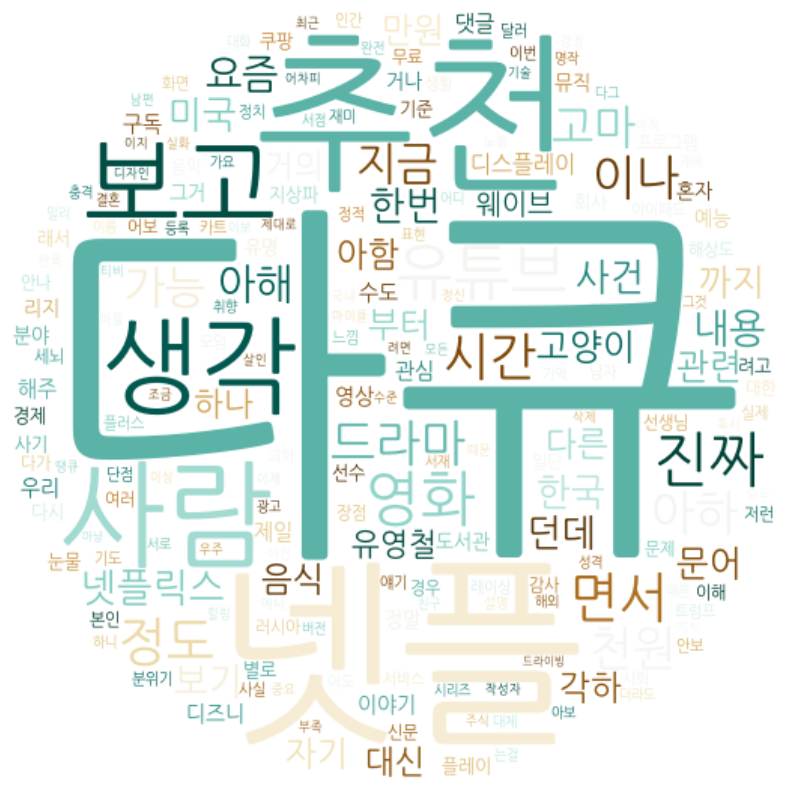

워드클라우드에서 제외해서 보고싶은 단어 리스트를 ','로 구분하여 입력하세요 (없으면 공백을 입력하세요) : 다큐, 넷플, 추천

다큐, 넷플, 추천 단어를 제외하여 다시 워드클라우드를 그립니다.


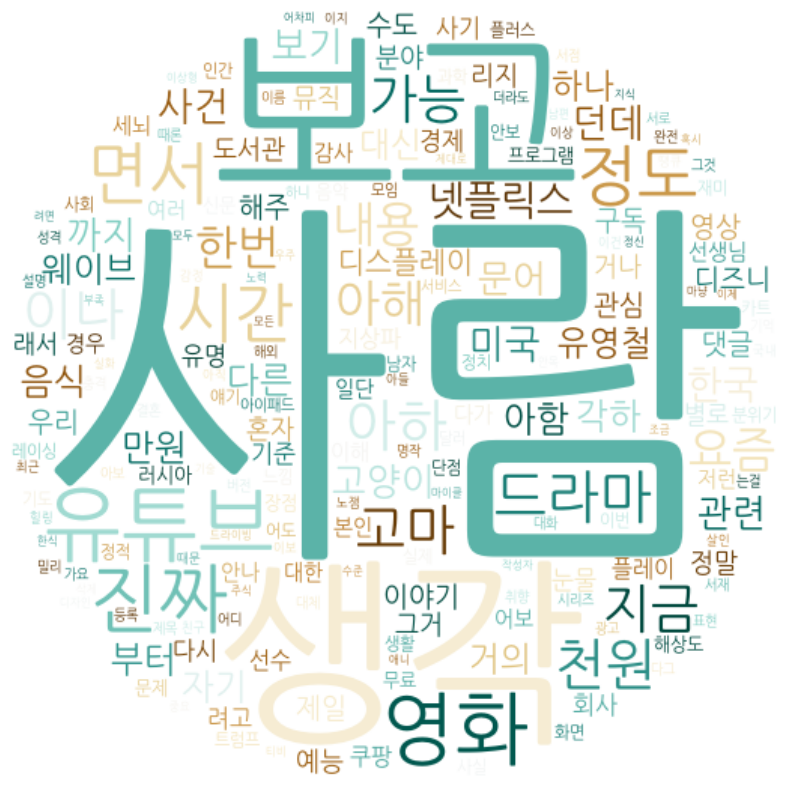

워드클라우드에서 제외해서 보고싶은 단어 리스트를 ','로 구분하여 입력하세요 (없으면 공백을 입력하세요) : 사람, 보고

사람, 보고 단어를 제외하여 다시 워드클라우드를 그립니다.


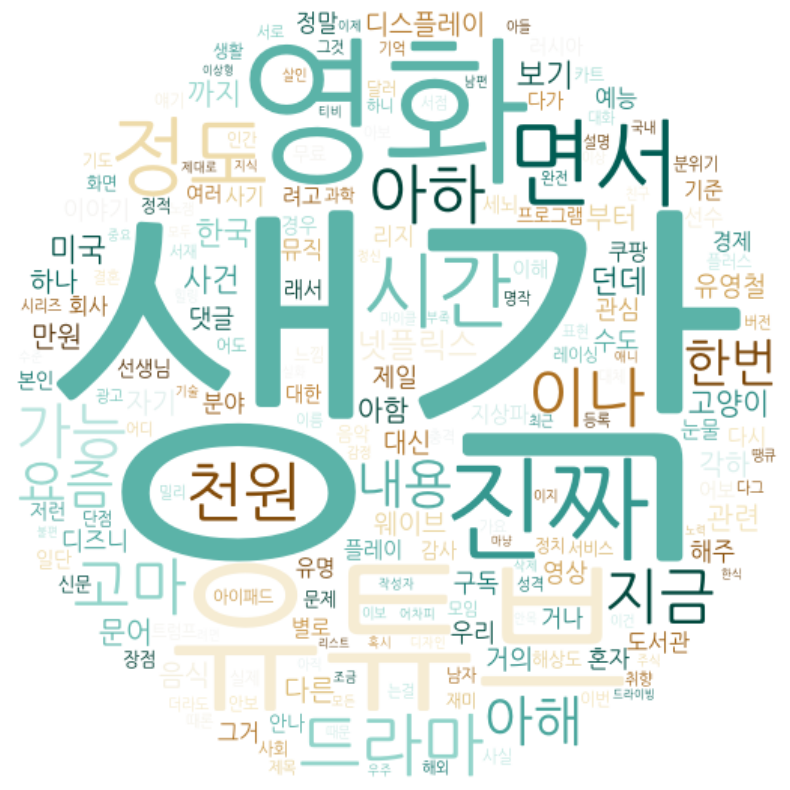

워드클라우드에서 제외해서 보고싶은 단어 리스트를 ','로 구분하여 입력하세요 (없으면 공백을 입력하세요) : 생각

생각 단어를 제외하여 다시 워드클라우드를 그립니다.


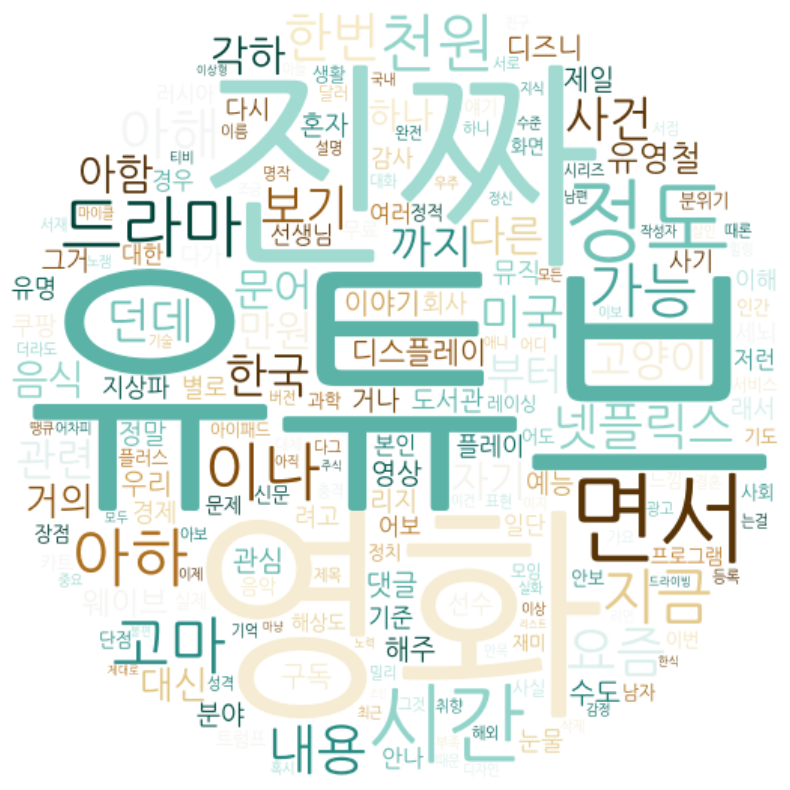

워드클라우드에서 제외해서 보고싶은 단어 리스트를 ','로 구분하여 입력하세요 (없으면 공백을 입력하세요) : 

워드클라우드 생성을 종료합니다.


In [4]:
%run bdp_final_project_20210388.py